# Data Generation

## Imports

In [105]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy import integrate
from pyDOE import lhs
from torch.utils import data
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [107]:
nice_params = {
    "text.usetex": True,
    "font.family": "serif",
    "font.serif" : "Computer Modern Roman",
    "font.size": 12,
    "axes.xmargin": False,
}
matplotlib.rcParams.update(nice_params)
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)

## Swing Equation

From Newton's second law:

$$T_a(t) = J\alpha_m(t)= T_m(t) - T_e(t)$$

where

$$\alpha_m(t) = \frac{dw_m(t)}{dt} = \frac{d^2\theta_m(t)}{dt^2}$$

$$w_m(t) = \frac{d\theta_m(t)}{dt}$$

$T$ = torque (accelerating, mechanical and electrical) \[$\text{N-m}$\]

$J$ = moment of inertia \[$\text{kg}-m^2$\]

$\alpha$ = rotor angular acceleration \[$\text{rad}/s^2$\]

$w$ = rotor angular velocity \[$\text{rad}/s$\]

$\theta$ = rotor angle \[$\text{rad}$\]



In steady-state $T_m = T_e$ which makes $T_a = 0$, i.e. rotor acceleration is zero and constant rotor velocity (synchronous speed).

If we measure rotor angular position w.r.t. reference axis (synchronous):

$$\theta_m(t) = w_{msyn}t+\delta_m(t)$$

$w_{msyn}$ = synchronous angular velocity of rotor \[$\text{rad}/s$\]

$\delta_m$ = rotor angular position w.r.t. synchronous reference \[$\text{rad}$\]

Then:

$$J\frac{d^2\theta_m(t)}{dt^2} = J \frac{d^2\delta_m(t)}{dt^2} = T_m(t) - T_e(t) = T_a(t)$$

If mulitplying both sides by $w_m$ (to get power) and dividing by $\text{S}_{rated}$ (to get p.u.):

$$\frac{Jw_m(t)}{\text{S}_{rated}}\frac{d^2\theta_m(t)}{dt^2} = p_{m, pu}(t) - p_{e, pu} = p_{a, pu}(t)$$

Adding the damping term:

$$\frac{Jw_m(t)}{\text{S}_{rated}}\frac{d^2\theta_m(t)}{dt^2} + \frac{Dd\delta}{dt} = p_{m, pu}(t) - p_{e, pu} = p_{a, pu}(t)$$

## ODE formulation

Now that we defined the equation:

$$m_k \ddot{\delta} + d_k \dot{\delta} + B_{kj} V_k V_j sin(\delta) - P_k = 0$$

We can express this second-order differential equation into a system of ODEs. First we define the state-vector:

$$\begin{bmatrix}x_1 \\ x_2\end{bmatrix} = \begin{bmatrix}
\delta\\
\dot{\delta}
\end{bmatrix}$$

where

$$\frac{d}{dt}\begin{bmatrix} \delta \\ \dot{\delta} \end{bmatrix} = \begin{bmatrix} \dot{\delta} \\ \ddot{\delta} \end{bmatrix}$$

$$\begin{bmatrix} \dot{\delta} \\ \ddot{\delta} \end{bmatrix} = \begin{bmatrix} \dot{\delta} \\ \frac{P_1 - d \dot{\delta} - B\ \text{sin}\left( \delta_i - \delta_j \right)}{m} \end{bmatrix}$$

and, since $\delta_j$ is always zero in our case:

$$\begin{bmatrix} \dot{\delta} \\ \ddot{\delta} \end{bmatrix} = \begin{bmatrix} \dot{\delta} \\ \frac{P_1 - d \dot{\delta} - B\ \text{sin}\left( \delta \right)}{m} \end{bmatrix}$$

## Functions

In [2]:
class Dataset(data.Dataset):
    """Creates a Dataset depending on the given matrices.
    
    Attributes:
        inputs(np.ndarray): Sliced matrix of inputs.
        p_type(np.ndarray): Sliced matrix of point type (from inputs).
        targets(np.ndarray): Sliced matrix of targets.
        n_u(int): Number of data points.
        n_f(int): Number of collocation points.
    
    Returns:
        X(np.ndarray): Input observation at idx.
        y(np.ndarray): Target observation at idx.
        p_type(np.ndarray): Point type at idx
    """
    def __init__(self, data_params, collocation=True, train=True, split=0.8):
        """Inits the Dataset, depends on collocation flag.
        
        Args:
        inputs(np.ndarray): Matrix of inputs.
        targets(np.ndarray): Matrix of targets.
        data_params(Dict): Includes the parameters of the dataset.
        collocation(bool): Indicates if the matrices should be sliced _
            to only include data points or also collocation points.
        """
        
        # Unpack parameters
        self.n_u = data_params['n_data']
        self.n_f = data_params['n_collocation']
        self.seed = data_params['seed']
        
        X_u, X_f, y, y_omega = self.create_dataset(data_params)
        
        X_train, X_test, y_train, y_test = train_test_split(X_u, y,
                                                            train_size=split,
                                                            random_state=self.seed)
        
        idx = np.random.choice(X_train.shape[0], self.n_u, replace=False)
        X_u_train = X_train[idx, 0:2]
        p_train = X_train[idx, -1].reshape((-1,1))
        y_train = y_train[idx, :]
        
        if collocation:
            X_train = np.vstack((X_u_train, X_f[:, 0:2]))
            p_train = np.vstack((p_train, X_f[:, -1].reshape((-1,1))))
            y_train = np.vstack((y_train, np.zeros((self.n_f, 1))))
        else:
            X_train = X_u_train
        
        if train:
            self.inputs = X_train
            self.p_type = p_train
            self.targets = y_train
        else:
            self.inputs = X_test[:, 0:2]
            self.p_type = X_test[:, -1].reshape((-1,1))
            self.targets = y_test

    def __len__(self):
        """Returns the size of the dataset."""
        return len(self.targets)

    def __getitem__(self, idx):
        """Retrieve inputs and targets at the given index."""
        X = torch.Tensor(self.inputs[idx])
        p_type = torch.Tensor(self.p_type[idx])
        y = torch.Tensor(self.targets[idx])

        return X, p_type, y
    
    def create_dataset(self, params):
        """Creates a dataset based on solving the swing equation on given parameters.

        Args:
            params: Dictionary containing relevant parameters.

        Returns:
            X: Inputs  [x_power, x_time, type]
            Y_delta: Target [delta]
            Y_omega: Secondary target [omega]
        """

        # Unpack parameters
        p_min, p_max = params['p_span']
        t_min, t_max = params['t_span']
        n_data = params['n_data']
        n_collocation = params['n_collocation']
        seed = params['seed']
        
        n_total = n_data + n_collocation

        # TODO move to main()?
        np.random.seed(seed)

        # Define upper and lower bounds
        lb = np.array([p_min, t_min])
        ub = np.array([p_max, t_max])

        # Define span of power disturbance    
        p_span = np.linspace(p_min, p_max, n_data)
        t_span = np.linspace(t_min, t_max, n_data).reshape((-1,1))

        # Preallocate datasets in memory
        X_u = np.ones((n_data, n_data, 3)) # [[power, t_span, ones], 3]
        X_f = np.zeros((n_collocation, 3)) # [[power, t_span, zeros], 3]
        y_delta = np.empty((n_data, n_data, 1)) # [trajectory, delta, 1]
        y_omega = np.empty((n_data, n_data, 1)) # [trajectory, omega, 1]

        # Solve for each power disturbance and save to matrices
        for idx, P in enumerate(p_span):
            params['power'] = P
            sol = self.solve_swing_eq(params)
            X_u[idx][:, :2] = np.concatenate([np.repeat(P, n_data).reshape((-1,1)), t_span], axis=1)
            y_delta[idx] = sol[0].reshape((-1,1))
            y_omega[idx] = sol[1].reshape((-1,1))

        # Create collocation points matrix
        X_f[:, :2] = lb + (ub - lb) * lhs(2, n_collocation)

        return X_u.reshape((-1,3)), X_f, y_delta.reshape((-1,1)), y_omega.reshape((-1,1))
    
    def solve_swing_eq(self, params):
        """Solves the swing equation with pre-defined parameters.

        Args:
            params: Dictionary containing relevant parameters.

        Returns:
            states: Solution of the swing equation (angle)
        """

        # Unpack parameters
        m = params['inertia']
        d = params['damping']
        B = params['susceptance']
        P = params['power']
        delta_0 = np.array([params['delta_0']])
        omega_0 = np.array([params['omega_0']])
        t_span = params['t_span'] # (t_min, t_max)
        n_data = params['n_data']

        # Define analysis time period
        t_eval = np.linspace(t_span[0], t_span[1], n_data)

        # Pack initial state
        initial_states = np.concatenate([delta_0, omega_0])

        # Solve ODE
        ode_solution = integrate.solve_ivp(self.swing_equation,
                                           t_span=t_span,
                                           y0=initial_states,
                                           args=[m, d, B, P],
                                           t_eval=t_eval)

        # Extract solution only
        states = ode_solution.y

        return states
    
    def swing_equation(self, t, x, m, d, B, P):
        r""" Swing equation expressed as a system of ODEs.

        Given by the formula:

        .. math::
            m_i \ddot{\delta} + d_i \dot{\delta} + B_{ij} V_i V_j sin(\delta) - P_i = 0

        Args:
            x: State vector [delta_i, omega_i]
            m: Inertia of the machine
            d: Damping coefficient
            B: Bus susceptance matrix
            P: Power injection or retrieval

        Returns:
            x_new: Updated state vector [delta_i, omega_i]
        """
        # Split the state variable into delta and omega
        state_delta = x[0]
        state_omega = x[1]

        # Computing the non-linear term in the swing equation sum_j (B_ij sin(delta_i - delta_j))
        delta_i = state_delta
        delta_j = np.zeros_like(delta_i)
        delta_ij = np.sin(delta_i - delta_j)
        connectivity_vector = np.sum(np.multiply(B, delta_ij))

        # Preallocate memory
        state_delta_new = np.zeros_like(state_delta)
        state_omega_new = np.zeros_like(state_omega)

        # Update states
        state_delta_new = state_omega
        state_omega_new = 1 / m * (P - d * state_omega - connectivity_vector)

        return np.array([state_delta_new, state_omega_new])

In [2]:
# Data generation functions

def init_dataset(X_u, X_f, y, data_params, collocation=True, train=True, split=0.95, shuffle=False, normalize=True):
    """Inits the Dataset, depends on collocation flag.
    
    Args:
    inputs(np.ndarray): Matrix of inputs.
    targets(np.ndarray): Matrix of targets.
    data_params(Dict): Includes the parameters of the dataset.
    collocation(bool): Indicates if the matrices should be sliced _
        to only include data points or also collocation points.
    """
    
    # Unpack parameters
    n_u = data_params['n_data']
    n_f = data_params['n_collocation']
    seed = data_params['seed']
    t_max = data_params['t_span'][1]
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_u, y,
                                                        train_size=split,
                                                        random_state=seed)
    
    # Select N_u datapoints
    idx = np.random.choice(X_train.shape[0], n_u, replace=False)
    X_u_train = X_train[idx, 0:2]
    p_train = X_train[idx, -1].reshape((-1,1))
    y_train = y_train[idx, :].reshape((-1,1))
    
    if collocation:
        # Select N_f datapoints
        idx = np.random.choice(X_f.shape[0], n_f, replace=False)
        X_train = np.vstack((X_u_train, X_f[idx, 0:2]))
        p_train = np.vstack((p_train, X_f[idx, -1].reshape((-1,1))))
        y_train = np.vstack((y_train, np.zeros((n_f, 1))))
    else:
        X_train = X_u_train
    
    if train:
        p = X_train[:, 0].reshape((-1,1))
        t = X_train[:, 1].reshape((-1,1))
        p_type = p_train
        targets = y_train
    else:
        p = X_test[:, 0].reshape((-1,1))
        t = X_test[:, 1].reshape((-1,1))
        p_type = X_test[:, -1].reshape((-1,1))
        targets = y_test

    # Normalize time
    if normalize:
        t = t/t_max

    # Random shuffle
    if shuffle:
        idx = np.random.permutation(p.shape[0])
        p = p[idx]
        t = t[idx]
        p_type = p_type[idx]
        targets = targets[idx]

    return [p, t, p_type, targets]

def swing_equation(t, x, m, d, B, P):
    r""" Swing equation expressed as a system of ODEs.
    
    Given by the formula:
    
    .. math::
        m_i \ddot{\delta} + d_i \dot{\delta} + B_{ij} V_i V_j sin(\delta) - P_i = 0
    
    Args:
        x: State vector [delta_i, omega_i]
        m: Inertia of the machine
        d: Damping coefficient
        B: Bus susceptance matrix
        P: Power injection or retrieval
    
    Returns:
        x_new: Updated state vector [delta_i, omega_i]
    """
    # Split the state variable into delta and omega
    state_delta = x[0]
    state_omega = x[1]

    # Computing the non-linear term in the swing equation sum_j (B_ij sin(delta_i - delta_j))
    delta_i = state_delta
    delta_j = np.zeros_like(delta_i)
    delta_ij = np.sin(delta_i - delta_j)
    connectivity_vector = np.sum(np.multiply(B, delta_ij))

    # Preallocate memory
    state_delta_new = np.zeros_like(state_delta)
    state_omega_new = np.zeros_like(state_omega)
    
    # Update states
    state_delta_new = state_omega
    state_omega_new = 1 / m * (P - d * state_omega - connectivity_vector)

    return np.array([state_delta_new, state_omega_new])

def solve_swing_eq(params):
    """Solves the swing equation with pre-defined parameters.
    
    Args:
        params: Dictionary containing relevant parameters.
    
    Returns:
        states: Solution of the swing equation (angle)
    """

    # Unpack parameters
    m = params['inertia']
    d = params['damping']
    B = params['susceptance']
    P = params['power']
    delta_0 = np.array([params['delta_0']])
    omega_0 = np.array([params['omega_0']])
    t_span = params['t_span'] # (t_min, t_max)
    n_data = params['n_data']
    
    # Define analysis time period
    t_eval = np.linspace(t_span[0], t_span[1], n_data)
    
    # Pack initial state
    initial_states = np.concatenate([delta_0, omega_0])
    
    # Solve ODE
    ode_solution = integrate.solve_ivp(swing_equation,
                                       t_span=t_span,
                                       y0=initial_states,
                                       args=[m, d, B, P],
                                       t_eval=t_eval)
    
    # Extract solution only
    states = ode_solution.y
    
    return states

def create_dataset(params):
    """Creates a dataset based on solving the swing equation on given parameters.
    
    Args:
        params: Dictionary containing relevant parameters.
    
    Returns:
        X: Inputs  [x_power, x_time, type]
        Y_delta: Target [delta]
        Y_omega: Secondary target [omega]
    """
        
    # Unpack parameters
    p_min, p_max = params['p_span']
    t_min, t_max = params['t_span']
    n_data = params['n_data']
    n_collocation = params['n_collocation']
    seed = params['seed']
    
    # TODO move to main()?
    np.random.seed(seed)
    
    # Define upper and lower bounds
    lb = np.array([p_min, t_min])
    ub = np.array([p_max, t_max])
    
    # Define span of power disturbance    
    p_span = np.linspace(p_min, p_max, n_data)
    t_span = np.linspace(t_min, t_max, n_data).reshape((-1,1))
    
    # Preallocate datasets in memory
    X_u = np.ones((n_data, n_data, 3)) # [trajectory, [power, t_span, ones], 3]
    X_f = np.zeros((n_collocation, 3)) # [power, t_span, zeros], 3]
    y_delta = np.empty((n_data, n_data, 1)) # [trajectory, delta, 1]
    y_omega = np.empty((n_data, n_data, 1)) # [trajectory, omega, 1]
    
    # Solve for each power disturbance and save to matrices
    for idx, P in enumerate(p_span):
        params['power'] = P
        sol = solve_swing_eq(params)
        X_u[idx][:, :2] = np.concatenate([np.repeat(P, n_data).reshape((-1,1)), t_span], axis=1)
        y_delta[idx] = sol[0].reshape((-1,1))
        y_omega[idx] = sol[1].reshape((-1,1))
    
    # Create collocation points matrix
    X_f[:, :2] = lb + (ub - lb) * lhs(2, n_collocation)
    
    # Stack matrices
    #X = np.vstack((X_u.reshape(-1, 3), X_f))
    #y_delta = np.vstack((y_delta.reshape((-1,1)), np.zeros((n_collocation, 1)))) # include collocation points
    #y_omega = np.vstack((y_omega.reshape((-1,1)), np.zeros((n_collocation, 1)))) # include collocation points
    
    return X_u.reshape((-1,3)), X_f, y_delta.reshape((-1,1)), y_omega.reshape((-1,1))

In [59]:
# Data visualization functions

def plot_sol(y_delta, y_omega, idx):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    t = np.linspace(t_min, t_max, n_data)
    ax1.plot(t, y_delta[idx*n_data : idx*n_data+n_data])
    ax1.set_title("Rotor angle vs. Time")
    ax1.set(xlabel="Time [s]", ylabel="$\delta$ [rad]")
    ax2.plot(t, y_omega[idx*n_data : idx*n_data+n_data], 'r')
    ax2.set_title("Angular speed vs. Time")
    ax2.set(xlabel="Time [s]", ylabel="$\omega$ [rad/s]")
    plt.tight_layout()

def plot_trajectory(y_delta, y_omega, idx):
    plt.plot(y_delta[idx*n_data : idx*n_data+n_data],
             y_omega[idx*n_data : idx*n_data+n_data])
    plt.title("Trajectory plot")
    plt.xlabel("$\delta$ [rad]")
    plt.ylabel("$\omega$ [rad/s]")

def plot_phase(y_delta, y_omega, idx, X):
    power = X[idx*n_data, 0]
    lim = math.ceil(y_delta.max())
    delta = np.linspace(-lim, lim, 20)
    omega = np.linspace(-lim, lim, 20)
    dlt, omg  = np.meshgrid(delta, omega)

    u, v = np.zeros(dlt.shape), np.zeros(omg.shape)

    n_i, n_j = dlt.shape

    for i in range(n_i):
        for j in range(n_j):
            x = dlt[i, j]
            y = omg[i, j]
            sol_v = swing_equation(1, np.array([x, y]), m, d, B, power)
            u[i,j] = sol_v[0]
            v[i,j] = sol_v[1]

    M = (np.hypot(u, v)) # get length of vector
    M[ M == 0] = 1. # avoid zero division errors 
    u /= M # normalize
    v /= M # normalize

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.quiver(dlt, omg, u, v, M)
    ax.plot(y_delta[idx*n_data : idx*n_data+n_data],
            y_omega[idx*n_data : idx*n_data+n_data], 'r')
    ax.set_title("Phase plot")
    ax.set(xlabel="$\delta$ [rad]", ylabel="$\omega$ [rad/s]")
    fig.show()

## Driver

In [4]:
# Parameters
n_data = 101 # number of data points per trajectory
n_collocation = 8000 # number of collocation points

m = 0.15 # angular inertia
d = 0.15 # damping coefficient
B = 0.2 # susceptance [pu]
delta_0 = 0 # initial angle [rad]
omega_0 = 0 # initial angular speed [rad/s]

p_min = 0.01 # minimum power [pu]
p_max = 0.3 # maximum power [pu]
p_span = (p_min, p_max)

t_min = 0
t_max = 20 # [seconds]
t_span = (t_min, t_max)

seed = 1

data_params = {'n_data': n_data,
               'n_collocation': n_collocation,
               'inertia': m,
               'damping': d,
               'susceptance': B,
               'delta_0': delta_0,
               'omega_0': omega_0,
               'p_span': p_span,
               't_span': t_span,
               'seed': seed
              }

In [5]:
X_u, X_f, y_delta, y_omega = create_dataset(data_params)

In [6]:
print(f"Input shape: {X_u.shape}\n"
      f"Input shape: {X_f.shape}\n"
      f"Output shape: {y_delta.shape}\n"
      f"Output shape: {y_omega.shape}")

Input shape: (10201, 3)
Input shape: (8000, 3)
Output shape: (10201, 1)
Output shape: (10201, 1)


In [7]:
X_u[0:10,:]

array([[0.01, 0.  , 1.  ],
       [0.01, 0.2 , 1.  ],
       [0.01, 0.4 , 1.  ],
       [0.01, 0.6 , 1.  ],
       [0.01, 0.8 , 1.  ],
       [0.01, 1.  , 1.  ],
       [0.01, 1.2 , 1.  ],
       [0.01, 1.4 , 1.  ],
       [0.01, 1.6 , 1.  ],
       [0.01, 1.8 , 1.  ]])

In [9]:
# np.savez('data.npz', X_u=X_u, X_f=X_f, y_delta=y_delta, y_omega=y_omega)

In [10]:
# dataset = Dataset(data_params, collocation=True)

In [11]:
# print(f"Input shape: {dataset.inputs.shape}\n"
#       f"Input shape: {dataset.targets.shape}\n"
#       f"Output shape: {dataset.p_type.shape}")

# Data visualization

In [8]:
len(X_u[:,0])/n_data

101.0

In [9]:
np.linspace(p_min, p_max, n_data)

array([0.01  , 0.0129, 0.0158, 0.0187, 0.0216, 0.0245, 0.0274, 0.0303,
       0.0332, 0.0361, 0.039 , 0.0419, 0.0448, 0.0477, 0.0506, 0.0535,
       0.0564, 0.0593, 0.0622, 0.0651, 0.068 , 0.0709, 0.0738, 0.0767,
       0.0796, 0.0825, 0.0854, 0.0883, 0.0912, 0.0941, 0.097 , 0.0999,
       0.1028, 0.1057, 0.1086, 0.1115, 0.1144, 0.1173, 0.1202, 0.1231,
       0.126 , 0.1289, 0.1318, 0.1347, 0.1376, 0.1405, 0.1434, 0.1463,
       0.1492, 0.1521, 0.155 , 0.1579, 0.1608, 0.1637, 0.1666, 0.1695,
       0.1724, 0.1753, 0.1782, 0.1811, 0.184 , 0.1869, 0.1898, 0.1927,
       0.1956, 0.1985, 0.2014, 0.2043, 0.2072, 0.2101, 0.213 , 0.2159,
       0.2188, 0.2217, 0.2246, 0.2275, 0.2304, 0.2333, 0.2362, 0.2391,
       0.242 , 0.2449, 0.2478, 0.2507, 0.2536, 0.2565, 0.2594, 0.2623,
       0.2652, 0.2681, 0.271 , 0.2739, 0.2768, 0.2797, 0.2826, 0.2855,
       0.2884, 0.2913, 0.2942, 0.2971, 0.3   ])

In [64]:
np.linspace(p_min, p_max, n_data)[31]

0.09989999999999999

In [35]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [11]:
# Select trajectory to plot
idx = 0

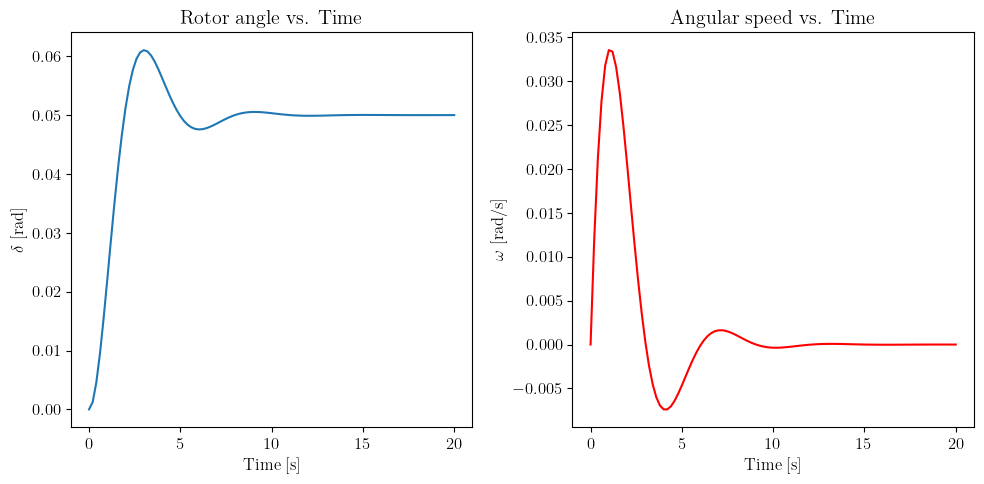

In [56]:
idx = 0
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
t = np.linspace(t_min, t_max, n_data)
ax1.plot(t, y_delta[idx*n_data : idx*n_data+n_data])
ax1.set_title("Rotor angle vs. Time")
ax1.set(xlabel="Time [s]", ylabel="$\delta$ [rad]")
ax2.plot(t, y_omega[idx*n_data : idx*n_data+n_data], 'r')
ax2.set_title("Angular speed vs. Time")
ax2.set(xlabel="Time [s]", ylabel="$\omega$ [rad/s]")
plt.tight_layout()

<ipython-input-157-7ed7682bf5e1>:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('rotor_angle.png', dpi=150)
/home/jorge/miniconda3/envs/ml4ps_pyro/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


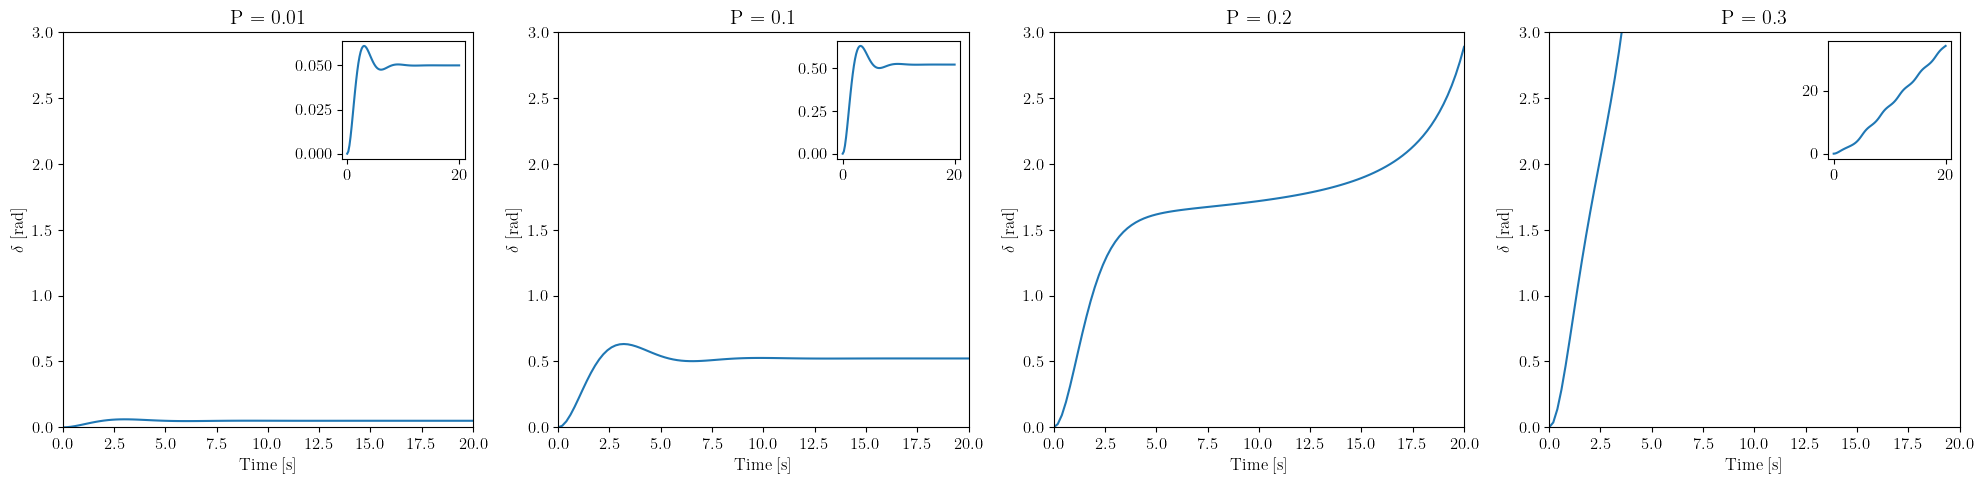

In [157]:
idxs = [0, 31, 66, 100]
top = ['0.01', '0.1', '0.2', '0.3']
t = np.linspace(t_min, t_max, n_data)

fig, axs = plt.subplots(1, 4, figsize=(20, 5), tight_layout=True)

for i, idx in enumerate(idxs):
    axs[i].plot(t, y_delta[idx*n_data : idx*n_data+n_data])
    axs[i].set_title(f"P = {top[i]}")
    axs[i].set(xlabel="Time [s]", ylabel="$\delta$ [rad]")
    axs[i].set(ylim=[0, 3])
    axs[i].margins(0)
    if i != 2:
        inner_ax = inset_axes(axs[i], width="30%", height="30%", loc=1)
        inner_ax.plot(t, y_delta[idx*n_data : idx*n_data+n_data])
    #inner_ax.margins(0)
    #right_inset_ax.set(xticks=[], yticks=[])

plt.savefig('rotor_angle.png', dpi=150)

<ipython-input-156-b9f2869d44de>:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('rotor_speed.png', dpi=150)
/home/jorge/miniconda3/envs/ml4ps_pyro/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


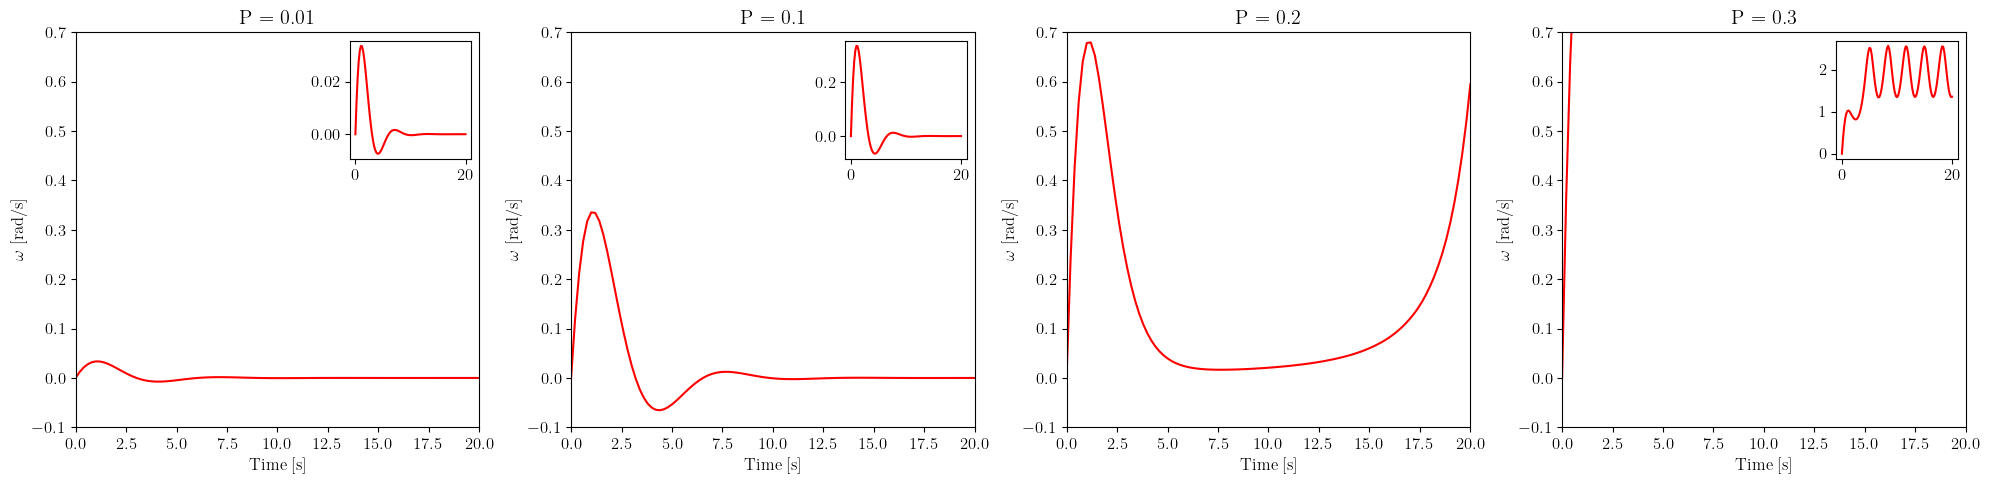

In [156]:
idxs = [0, 31, 66, 100]
top = ['0.01', '0.1', '0.2', '0.3']
t = np.linspace(t_min, t_max, n_data)

fig, axs = plt.subplots(1, 4, figsize=(20, 5), tight_layout=True)

for i, idx in enumerate(idxs):
    axs[i].plot(t, y_omega[idx*n_data : idx*n_data+n_data], 'r')
    axs[i].set_title(f"P = {top[i]}")
    axs[i].set(xlabel="Time [s]", ylabel="$\omega$ [rad/s]")
    axs[i].set(ylim=[-0.1, 0.7])
    axs[i].margins(0)
    if i != 2:
        inner_ax = inset_axes(axs[i], width="30%", height="30%", loc=1)
        inner_ax.plot(t, y_omega[idx*n_data : idx*n_data+n_data], 'r')
    #inner_ax.margins(0)
    #right_inset_ax.set(xticks=[], yticks=[])
plt.savefig('rotor_speed.png', dpi=150)

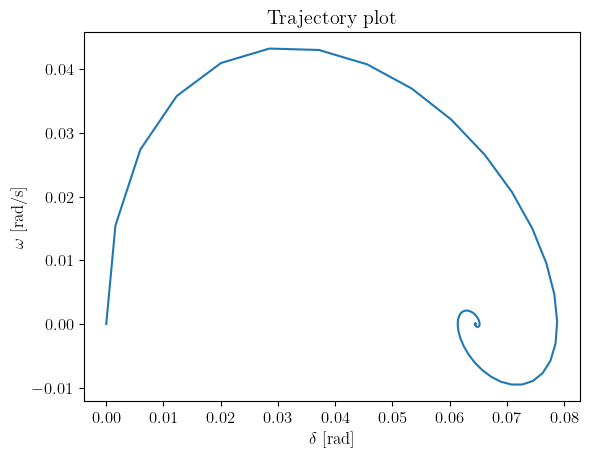

In [60]:
plot_trajectory(y_delta, y_omega, 1)

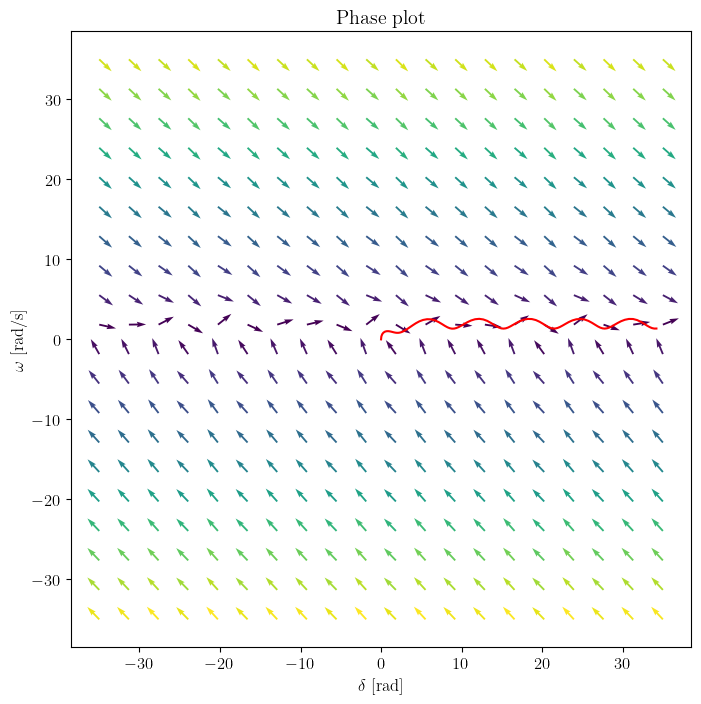

In [61]:
plot_phase(y_delta, y_omega, 100, X_u)

/home/jorge/miniconda3/envs/ml4ps_pyro/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


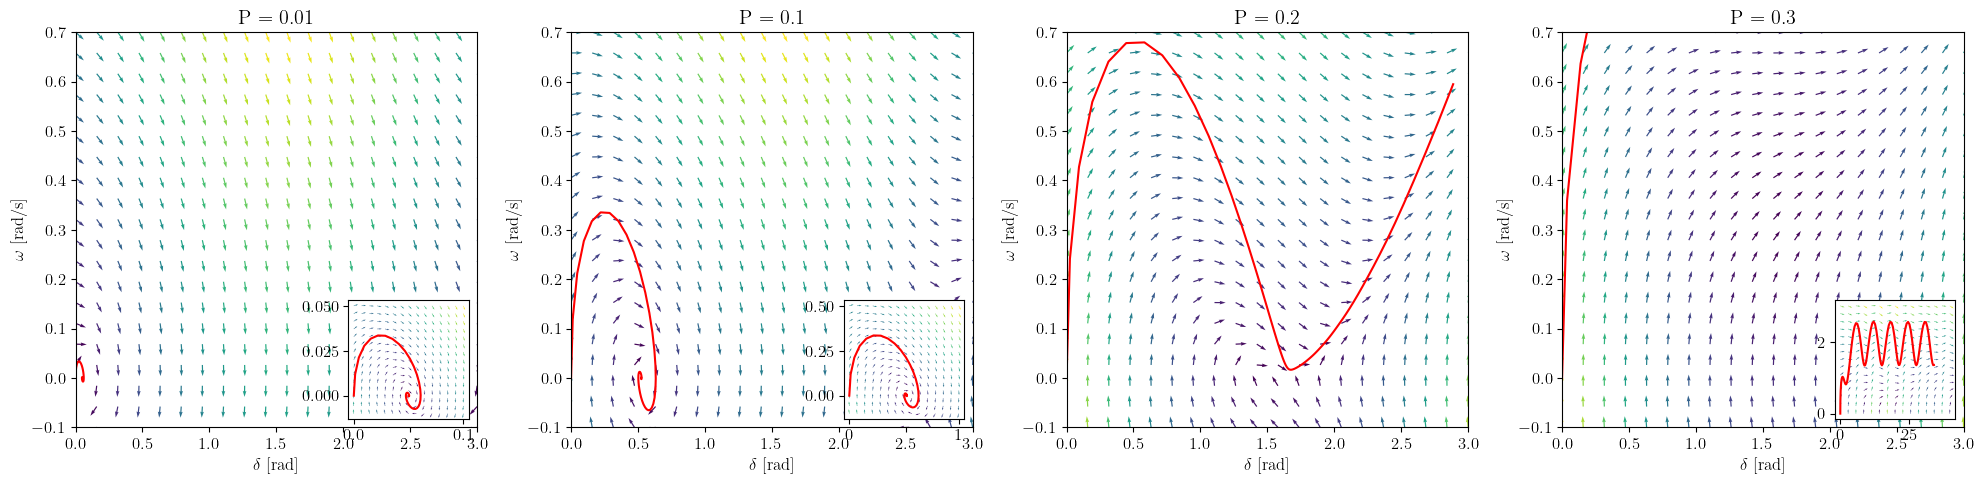

In [164]:
idxs = [0, 31, 66, 100]
top = ['0.01', '0.1', '0.2', '0.3']
lims_delta = {0: (0, 0.1, 15), 1: (0, 1, 15), 2: (0, 3, 15)}
lims_omega = {0: (-0.01, 0.05, 15), 1: (-0.1, 0.5, 15), 2: (-0.1, 0.7, 15)}
t = np.linspace(t_min, t_max, n_data)

fig, axs = plt.subplots(1, 4, figsize=(20, 5), tight_layout=True)

for ix, idx in enumerate(idxs):
    power = X_u[idx*n_data, 0]
    #lim = math.ceil(y_delta[idx*n_data : idx*n_data+n_data].max())/10
    delta = np.linspace(0, 3, 20)
    omega = np.linspace(-0.1, 0.7, 20)
    dlt, omg  = np.meshgrid(delta, omega)

    u, v = np.zeros(dlt.shape), np.zeros(omg.shape)

    n_i, n_j = dlt.shape

    for i in range(n_i):
        for j in range(n_j):
            x = dlt[i, j]
            y = omg[i, j]
            sol_v = swing_equation(1, np.array([x, y]), m, d, B, power)
            u[i,j] = sol_v[0]
            v[i,j] = sol_v[1]

    M = (np.hypot(u, v)) # get length of vector
    M[ M == 0] = 1. # avoid zero division errors 
    u /= M # normalize
    v /= M # normalize

    axs[ix].quiver(dlt, omg, u, v, M)
    axs[ix].plot(y_delta[idx*n_data : idx*n_data+n_data],
            y_omega[idx*n_data : idx*n_data+n_data], 'r')
    axs[ix].set_title(f"P = {top[ix]}")
    axs[ix].set(xlabel="$\delta$ [rad]", ylabel="$\omega$ [rad/s]")
    axs[ix].set(xlim=[0, 3])
    axs[ix].set(ylim=[-0.1, 0.7])
    
    if ix==3:
        delta = np.linspace(0, 40, 15)
        omega = np.linspace(0, 3, 15)
    else:
        delta = np.linspace(*lims_delta[ix])
        omega = np.linspace(*lims_omega[ix])
        
    dlt, omg  = np.meshgrid(delta, omega)

    u, v = np.zeros(dlt.shape), np.zeros(omg.shape)

    n_i, n_j = dlt.shape

    for i in range(n_i):
        for j in range(n_j):
            x = dlt[i, j]
            y = omg[i, j]
            sol_v = swing_equation(1, np.array([x, y]), m, d, B, power)
            u[i,j] = sol_v[0]
            v[i,j] = sol_v[1]

    M = (np.hypot(u, v)) # get length of vector
    M[ M == 0] = 1. # avoid zero division errors 
    u /= M # normalize
    v /= M # normalize
    
    if ix != 2:
        inner_ax = inset_axes(axs[ix], width="30%", height="30%", loc=4)
        inner_ax.quiver(dlt, omg, u, v, M)
        inner_ax.plot(y_delta[idx*n_data : idx*n_data+n_data],
                y_omega[idx*n_data : idx*n_data+n_data], 'r')
    
# plt.savefig("phase_plot.png", dpi=150)